# Hands-On NLP - Class 2: Text Classification In-Class Exercise

**Goal:** Apply text classification techniques to distinguish between **Linguistics** and **Philosophy** StackExchange posts.

<span style="color:magenta">Group members:</span>

* JIN Zhuoyuan
* PENA CASTANO Javier
* LI Zeying


## Why These Domains?

Unlike the prep notebook (robotics vs mythology vs health...), **linguistics and philosophy share significant vocabulary overlap**:
- Both discuss abstract concepts, theories, and argumentation
- Both use academic English with similar sentence structures
- Many terms appear in both: "meaning", "language", "concept", "argument", "logic"

This makes classification **harder** and more interesting!

## Notebook Outline (Simplified)

| Part | Topic | Time |
|------|-------|------|
| **1** | Data Loading & Exploration | 15 min |
| **2** | TF-IDF Vectorization | 15 min |
| **3** | Binary Classification | 20 min |
| **4** | Vocabulary Analysis | 20 min |
| **5** | Multi-class Extension | 20 min |

**Total:** ~1h30

In [42]:
import collections
from collections import Counter

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import re
import random


# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Setup
tqdm.pandas()
sns.set_style("darkgrid")
pd.set_option("display.precision", 3)

## Part 1: Data Loading & Exploration

### 1.1 Load the New Datasets

We have two new StackExchange categories:
- **linguistics** — Questions about language structure, phonetics, syntax, semantics
- **philosophy** — Questions about ethics, metaphysics, logic, epistemology

Both have ~4000 documents each.

In [43]:
# Load the two new categories
DATA_DIR = Path("texts")
NEW_CORPORA = ["linguistics", "philosophy"]

data = []
for cat_id, corpus in enumerate(tqdm(NEW_CORPORA)):
    corpus_path = DATA_DIR / corpus
    if not corpus_path.exists():
        print(f"⚠️ Warning: {corpus_path} not found!")
        continue
    for text_file in corpus_path.glob("*.txt"):
        with open(text_file, "r", encoding="utf-8") as f:
            text = f.read()
        data.append({
            "text": text,
            "category": corpus,
            "cat_id": cat_id,
            "filename": text_file.name
        })

df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Loaded {len(df)} documents.")
print(df["category"].value_counts())

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]

Loaded 8000 documents.
category
linguistics    4000
philosophy     4000
Name: count, dtype: int64


### 1.2 🔍 Hands-On: Explore the Data

**Before any machine learning, you should LOOK at your data!**

Open a few text files manually (in VS Code or a text editor) and try to understand:
1. What does a typical document look like?
   In a typical linguistic document there is always some questions, and the answers to the questions, with two "speakers".
   In a typical philosophy document there are some conversations about differents "philosophical" themes.
   Both are in a majority full of text.
3. Can YOU tell the difference between linguistics and philosophy posts?
   The difference is that philosophy texts are longer, in linguistics there are more than 2 languages, and the philosophy text more alike debates than objectives answers.
5. What words do you think would help distinguish them?
   linguistic words: languages, english, language , word ,linguistics
   philosophy words:
   logical ,experience , god , proof ,philosophers 

In [44]:
# Look at a random linguistics example
ling_sample = df[df["category"] == "linguistics"].sample(1, random_state=123).iloc[0]
print("=" * 60)
print("LINGUISTICS EXAMPLE")
print(f"File: {ling_sample['filename']}")
print("=" * 60)
print(ling_sample["text"][:1500])

LINGUISTICS EXAMPLE
File: linguistics.stackexchange_0000014596.txt
Q:

What is the lexical relationship between 'kingdom' and 'phylum'?

In biology humans belong to the kingdom of animalia and the phylum chordata.
Every organism that belongs to chordata belongs also to animalia but not the other way around. Animalia is a hypernym of chordata.
However it doesn't feel like kingdom is a hypernym of phylum. Is there a word for the relationship between the concepts?

A:

"Kingdom" a higher taxonomic level, higher than "phylum". 
You can probably say "superlevel", if you desperately need it in one word, but I would rather say "higher level in the hierarchy/taxonomy/classification". 




In [45]:
# Look at a random philosophy example
phil_sample = df[df["category"] == "philosophy"].sample(1, random_state=456).iloc[0]
print("=" * 60)
print("PHILOSOPHY EXAMPLE")
print(f"File: {phil_sample['filename']}")
print("=" * 60)
print(phil_sample["text"][:1500])

PHILOSOPHY EXAMPLE
File: philosophy.stackexchange_0000008331.txt
Q:

Weber and Marx - Modern Culture and Dominant Culture

Not sure if this is the right forum, but this seems to be the best fit. IF there is a better forum, please direct me.
Marx and Weber are both concerned with the role of "culture" or "idea/ideology" on the material world. Obviously, Weber placing a greater emphasis on ideology than Marx does.
Marxists look at culture as Dominant Culture: the culture of the ruling class. This ideology legitimizes the domination of the ruling class (i.e., capitalists) and their exploitation of the masses (i.e., the proletariat).
Weberians (is that the right term?) see the hand of Modern Culture: the ideology of rationalization. While the ideology of rationalization is born from the material world (from a confluence of historical phenomenons), rationalization also has taken a life of its own. People rationalize for the sake of rationalization, not for greater efficiency or utility.
Now

In [46]:
# Basic statistics
df["text_len"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()

print("Dataset Statistics:")
print(df.groupby("category")[["text_len", "word_count"]].describe().round(0))

Dataset Statistics:
            text_len                                                          \
               count    mean     std    min     25%     50%     75%      max   
category                                                                       
linguistics   4000.0  2619.0  2050.0  169.0  1298.0  2089.0  3326.0  30628.0   
philosophy    4000.0  3695.0  2511.0  294.0  1994.0  3155.0  4748.0  31982.0   

            word_count                                                   
                 count   mean    std   min    25%    50%    75%     max  
category                                                                 
linguistics     4000.0  431.0  338.0  27.0  214.0  345.0  550.0  5046.0  
philosophy      4000.0  615.0  414.0  50.0  335.0  531.0  792.0  5273.0  


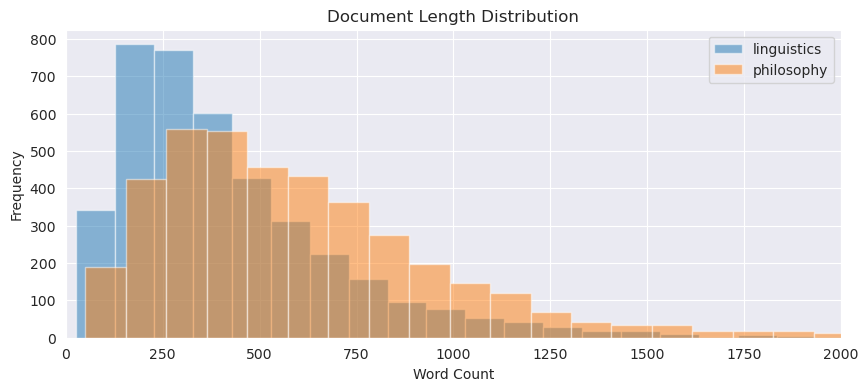

In [47]:
# Visualize document length distribution
fig, ax = plt.subplots(figsize=(10, 4))
for cat in NEW_CORPORA:
    subset = df[df["category"] == cat]
    ax.hist(subset["word_count"], bins=50, alpha=0.5, label=cat)
ax.set_xlabel("Word Count")
ax.set_ylabel("Frequency")
ax.set_title("Document Length Distribution")
ax.legend()
ax.set_xlim(0, 2000)
plt.show()

## Part 2: TF-IDF Vectorization

Transform text into numerical vectors using TF-IDF.

**Recall:**
$$ \text{TF-IDF}(t, d) = \text{TF}(t, d) \times \log\left(\frac{N}{\text{DF}(t)}\right) $$

- Words that appear everywhere ("the", "is") get low weights
- Words that are distinctive to certain documents get high weights

In [48]:
# Create TF-IDF vectors
# 🚧 TODO: Configure the TfidfVectorizer with appropriate parameters
tfidf_vec = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

# 🚧 TODO: Fit and transform the text data
X = tfidf_vec.fit_transform(df["text"])
y = df["cat_id"]

print(f"TF-IDF matrix shape: {X.shape}")
print(f"Vocabulary size: {len(tfidf_vec.vocabulary_)}")
print(f"Sparsity: {100 * (1 - X.nnz / (X.shape[0] * X.shape[1])):.1f}% zeros")

TF-IDF matrix shape: (8000, 5000)
Vocabulary size: 5000
Sparsity: 97.6% zeros


In [49]:
# Show some vocabulary words
vocab = tfidf_vec.get_feature_names_out()
print("Sample vocabulary words:")
print(list(vocab[:20]))
print("...")
print(list(vocab[-20:]))

Sample vocabulary words:
['00', '000', '10', '100', '1000', '11', '12', '13', '14', '15', '16', '17', '17th', '18', '18th', '19', '1970', '1984', '1986', '1990']
...
['yeah', 'year', 'years', 'yellow', 'yes', 'yesterday', 'yield', 'yields', 'york', 'young', 'younger', 'youtube', 'zarathustra', 'zeno', 'zero', 'zfc', 'zh', 'zombie', 'zombies', 'zulu']


## Part 3: Binary Classification (Linguistics vs Philosophy)

Now let's train classifiers to distinguish between these two domains.

In [50]:
# Train/Test Split
# 🚧 TODO: Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} documents")
print(f"Test set: {X_test.shape[0]} documents")

Training set: 6400 documents
Test set: 1600 documents


In [51]:
# Train Naive Bayes
# 🚧 TODO: Create and train a MultinomialNB classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
nb_pred = nb_clf.predict(X_test)

print("Naive Bayes Results:")
print(classification_report(y_test, nb_pred, target_names=NEW_CORPORA))

Naive Bayes Results:
              precision    recall  f1-score   support

 linguistics       0.99      0.98      0.98       800
  philosophy       0.98      0.99      0.98       800

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [52]:
# Train Logistic Regression
# 🚧 TODO: Create and train a LogisticRegression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, lr_pred, target_names=NEW_CORPORA))

Logistic Regression Results:
              precision    recall  f1-score   support

 linguistics       0.98      0.98      0.98       800
  philosophy       0.98      0.98      0.98       800

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [53]:
# Train Linear SVM
# 🚧 TODO: Create and train a LinearSVC classifier
svm_clf = LinearSVC(random_state=42, max_iter=2000)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

print("Linear SVM Results:")
print(classification_report(y_test, svm_pred, target_names=NEW_CORPORA))

Linear SVM Results:
              precision    recall  f1-score   support

 linguistics       0.98      0.98      0.98       800
  philosophy       0.98      0.98      0.98       800

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [54]:
# Compare classifiers
classifiers = {
    "Naive Bayes": nb_pred,
    "Logistic Regression": lr_pred,
    "Linear SVM": svm_pred
}

# 🚧 TODO: Calculate accuracy for each classifier and create a comparison table
comparison = []
for name, pred in classifiers.items():
    acc = (pred == y_test).mean()
    comparison.append({"Model": name, "Accuracy": acc})

comparison_df = pd.DataFrame(comparison)
print("\nClassifier Comparison:")
print(comparison_df.to_string(index=False))


Classifier Comparison:
              Model  Accuracy
        Naive Bayes     0.984
Logistic Regression     0.982
         Linear SVM     0.983


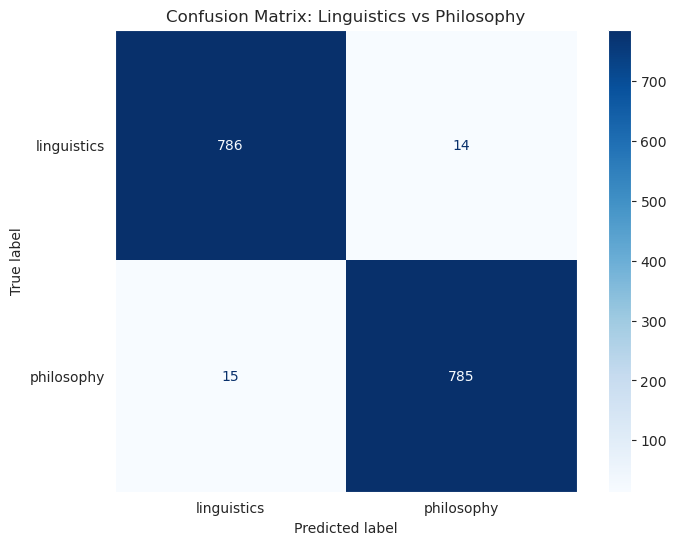

In [55]:
# Confusion Matrix for best model (use Logistic Regression for interpretability)
cm = confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=NEW_CORPORA)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix: Linguistics vs Philosophy")
plt.grid(False)
plt.show()

In [56]:
# Error Analysis: Find misclassified examples
df_test = df.iloc[y_test.index].copy()
df_test["predicted"] = lr_pred
df_test["correct"] = lr_pred == y_test.values

errors = df_test[~df_test["correct"]]
print(f"Number of errors: {len(errors)} out of {len(df_test)}")

# Show one misclassified example (linguistics → philosophy)
ling_to_phil = errors[(errors["cat_id"] == 0) & (errors["predicted"] == 1)]
if len(ling_to_phil) > 0:
    err = ling_to_phil.iloc[0]
    print(f"\n❌ MISCLASSIFIED EXAMPLE (linguistics → philosophy):")
    print(f"   True: linguistics | Predicted: philosophy")
    print(f"   File: {err['filename']}")
    print("-" * 50)
    print(err["text"][:800] + "...")

# Show one inversely misclassified example (philosophy → linguistics)
phil_to_ling = errors[(errors["cat_id"] == 1) & (errors["predicted"] == 0)]
if len(phil_to_ling) > 0:
    err = phil_to_ling.iloc[0]
    print(f"\n❌ MISCLASSIFIED EXAMPLE (philosophy → linguistics):")
    print(f"   True: philosophy | Predicted: linguistics")
    print(f"   File: {err['filename']}")
    print("-" * 50)
    print(err["text"][:800] + "...")

Number of errors: 29 out of 1600

❌ MISCLASSIFIED EXAMPLE (linguistics → philosophy):
   True: linguistics | Predicted: philosophy
   File: linguistics.stackexchange_0000038018.txt
--------------------------------------------------
Q:

Where can I find a modern overview of Luvian hieroglyphs?

According to Melchert, the reading of Hieroglyphic Luvian (HLuvian, HLuwian) was completely revolutionized in 1974 by Hawkins, Morpurgo-Davies, and Neumann.
However, I haven't been able to find an overview of HLuvian writing that incorporates these "new readings": an inventory of signs with their readings, an explanation of the use of logograms and determiners, etc.
Does such an overview exist? If so, where would I find one? (The more modern the better; I don't know how much readings have changed since 1974 but I assume there's been some progress there.)

A:

You can read Payne:
https://books.google.fr/books/about/Hieroglyphic_Luwian.html?id=x_F71ge6-EIC which is a textbook (I have it as a book)


## Part 4: Vocabulary Analysis

### 4.1 Most Distinctive Words per Category

Which words best distinguish linguistics from philosophy?

In [57]:
# Extract feature importance from Logistic Regression
feature_names = tfidf_vec.get_feature_names_out()
coefs = lr_clf.coef_[0]  # Binary classification has one coefficient vector

# 🚧 TODO: Sort words by coefficient to find most distinctive words per class
# Hint: negative coefficients → linguistics, positive coefficients → philosophy
sorted_indices = np.argsort(coefs)[::1]

n_top = 15

print("=" * 60)
print("MOST DISTINCTIVE WORDS")
print("=" * 60)

# 🚧 TODO: Print the top words for each category
print(f"\n📚 Top {n_top} words for LINGUISTICS (negative coefficients):")
for idx in sorted_indices[:n_top]:
    print(f"   {feature_names[idx]:20s} (coef: {coefs[idx]:+.3f})")

print(f"\n🤔 Top {n_top} words for PHILOSOPHY (positive coefficients):")
for idx in sorted_indices[-n_top:]:
    print(f"   {feature_names[idx]:20s} (coef: {coefs[idx]:+.3f})")

MOST DISTINCTIVE WORDS

📚 Top 15 words for LINGUISTICS (negative coefficients):
   languages            (coef: -5.713)
   english              (coef: -4.887)
   language             (coef: -3.960)
   word                 (coef: -3.852)
   verb                 (coef: -3.455)
   linguistics          (coef: -3.242)
   grammar              (coef: -2.914)
   words                (coef: -2.807)
   vowel                (coef: -2.757)
   noun                 (coef: -2.543)
   sound                (coef: -2.511)
   linguistic           (coef: -2.468)
   sentence             (coef: -2.415)
   syntax               (coef: -2.224)
   verbs                (coef: -2.190)

🤔 Top 15 words for PHILOSOPHY (positive coefficients):
   truth                (coef: +2.044)
   things               (coef: +2.066)
   moral                (coef: +2.091)
   statement            (coef: +2.104)
   experience           (coef: +2.107)
   proof                (coef: +2.192)
   god                  (coef: +2.197)
   phi

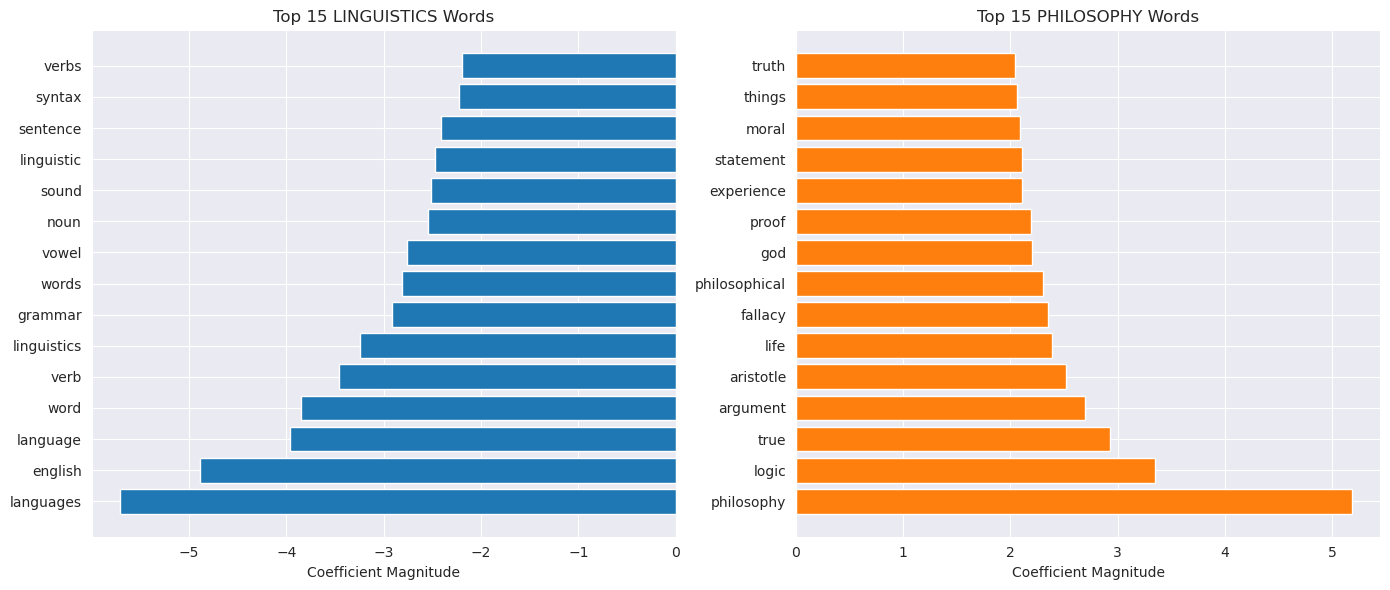

In [58]:
# Visualize top predictive words
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 🚧 TODO: Create horizontal bar plots for the top words in each category
# Linguistics (most negative coefficients)
ling_indices = sorted_indices[:15]
ling_words = [feature_names[i] for i in ling_indices]
ling_coefs = [coefs[i] for i in ling_indices]

axes[0].barh(ling_words, ling_coefs, color=plt.cm.tab10(0))
axes[0].set_xlabel("Coefficient Magnitude")
axes[0].set_title("Top 15 LINGUISTICS Words")

# Philosophy (most positive coefficients)
phil_indices = sorted_indices[-15:][::-1]
phil_words = [feature_names[i] for i in phil_indices]
phil_coefs = [coefs[i] for i in phil_indices]

axes[1].barh(phil_words, phil_coefs, color=plt.cm.tab10(1))
axes[1].set_xlabel("Coefficient Magnitude")
axes[1].set_title("Top 15 PHILOSOPHY Words")

plt.tight_layout()
plt.show()

### 4.2 Shared vs Distinctive Vocabulary

Let's explore what words these two academic domains share versus what makes them different.

In [59]:
# Find words with coefficients close to zero (shared between domains)
neutral_threshold = 0.1
# 🚧 TODO: Find words with small coefficients (shared vocabulary)
neutral_mask =np.abs(coefs)< neutral_threshold 
neutral_words = feature_names[neutral_mask]

# Sample some neutral words
print(f"Words with |coefficient| < {neutral_threshold} (shared vocabulary):")
print(f"Total: {len(neutral_words)} words")
random.seed(42)
sample_size = min(30, len(neutral_words))
print("\nExamples:", random.sample(list(neutral_words), sample_size))

Words with |coefficient| < 0.1 (shared vocabulary):
Total: 1634 words

Examples: ['separation', 'challenging', 'accurately', 'transitivity', 'fair', 'employ', 'dogmatic', 'comprehension', 'traditionally', 'capability', 'stable', 'transformed', 'presuppositions', 'bird', 'reflecting', 'luck', 'addressing', 'additional', 'branches', 'display', 'earlier', 'peoples', 'rendering', 'actor', 'publications', 'denotes', 'technically', 'shows', 'superficial', 'lose']


In [60]:
# Word frequency comparison
# Calculate mean TF-IDF per category for each word
ling_mask = df["category"] == "linguistics"
phil_mask = df["category"] == "philosophy"

X_ling = X[ling_mask.values]
X_phil = X[phil_mask.values]

# 🚧 TODO: Calculate mean TF-IDF for each word in each category
mean_ling = np.asarray(X_ling.mean(axis=0)).flatten()
mean_phil = np.asarray(X_phil.mean(axis=0)).flatten()

# Create comparison dataframe
word_comparison = pd.DataFrame({
    "word": feature_names,
    "mean_ling": mean_ling,
    "mean_phil": mean_phil,
    "ratio": (mean_ling + 0.0001) / (mean_phil + 0.0001),
    "coefficient": coefs
})
word_comparison

,word,mean_ling,mean_phil,ratio,coefficient
0,00,4.725e-04,2.636e-04,1.574,-0.139
1,000,1.832e-03,1.022e-03,1.722,-0.082
2,10,3.193e-03,4.603e-03,0.700,0.420
3,100,2.321e-03,1.986e-03,1.160,-0.136
4,1000,1.047e-03,5.003e-04,1.912,-0.180
...,...,...,...,...,...
4995,zfc,0.000e+00,1.336e-03,0.070,0.314
4996,zh,6.487e-04,0.000e+00,7.487,-0.076
4997,zombie,3.195e-05,6.548e-04,0.175,0.136
4998,zombies,0.000e+00,1.115e-03,0.082,0.182


In [61]:
# Words used similarly in both domains (high frequency in both)
# 🚧 TODO: Find words that appear frequently in BOTH domains
word_comparison["min_freq"] = word_comparison[["mean_ling", "mean_phil"]].min(axis=1)
shared_words = word_comparison[word_comparison["min_freq"] > 0.005].sort_values("min_freq", ascending=False)

print("Words commonly used in BOTH domains:")
print(shared_words[["word", "mean_ling", "mean_phil", "coefficient"]].head(20).to_string(index=False))

Words commonly used in BOTH domains:
     word  mean_ling  mean_phil  coefficient
     like      0.027      0.018       -1.250
 question      0.015      0.020        0.581
     know      0.014      0.017        0.343
     just      0.014      0.016        0.480
  example      0.018      0.014       -0.679
     does      0.014      0.021        0.943
different      0.017      0.013       -0.327
      don      0.014      0.012       -0.538
      say      0.011      0.017        0.819
   people      0.011      0.019        1.423
      use      0.017      0.011       -0.593
      way      0.011      0.017        0.968
    think      0.011      0.017        0.824
     case      0.013      0.011       -0.370
 language      0.051      0.010       -3.960
     time      0.010      0.019        1.055
  meaning      0.017      0.010       -0.582
     form      0.013      0.009       -0.676
      non      0.009      0.010       -0.241
    means      0.009      0.011        0.269


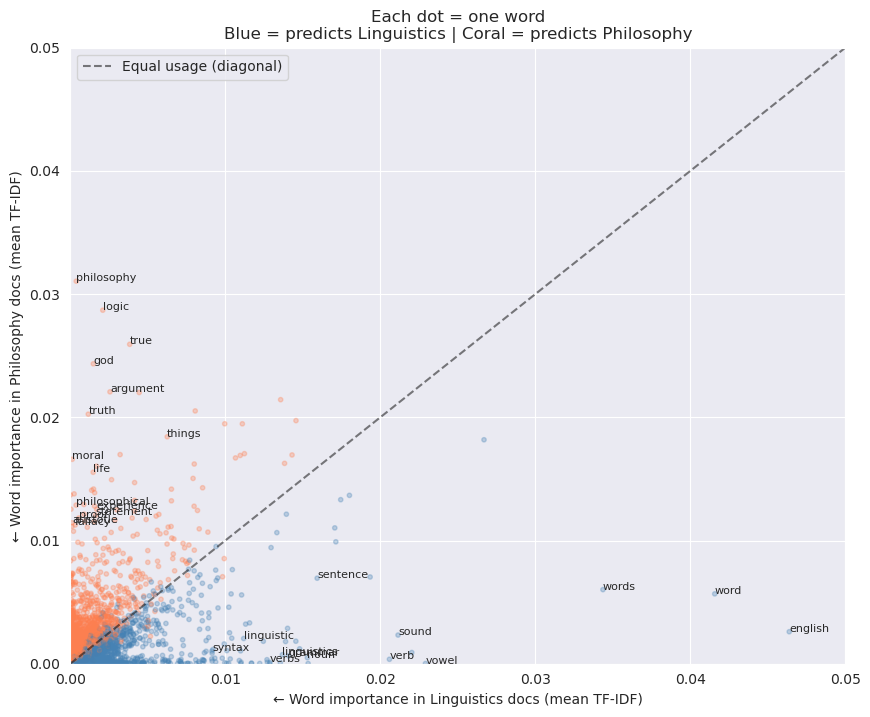

In [62]:
# Scatter plot: word usage in linguistics vs philosophy
plt.figure(figsize=(10, 8))

# Color by which domain uses the word more
colors = np.where(coefs > 0, "coral", "steelblue")

plt.scatter(mean_ling, mean_phil, c=colors, alpha=0.3, s=10)
plt.xlabel("← Word importance in Linguistics docs (mean TF-IDF)")
plt.ylabel("← Word importance in Philosophy docs (mean TF-IDF)")
plt.title("Each dot = one word\nBlue = predicts Linguistics | Coral = predicts Philosophy")

# Diagonal line (equal usage)
max_val = max(mean_ling.max(), mean_phil.max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label="Equal usage (diagonal)")

# Annotate some distinctive words
for idx in sorted_indices[:15]:  # Top linguistics words
    plt.annotate(feature_names[idx], (mean_ling[idx], mean_phil[idx]), fontsize=8)
for idx in sorted_indices[-15:]:  # Top philosophy words
    plt.annotate(feature_names[idx], (mean_ling[idx], mean_phil[idx]), fontsize=8)

plt.legend()
plt.xlim(0, 0.05)
plt.ylim(0, 0.05)
plt.show()

### 4.3 Compare with Previous Domains

Let's see how linguistics/philosophy vocabulary compares to other domains from the prep notebook.

In [63]:
# Load a sample from previous domains for comparison
OLD_CORPORA = ["health", "robotics"]
old_data = []

for corpus in OLD_CORPORA:
    corpus_path = DATA_DIR / corpus
    if corpus_path.exists():
        files = list(corpus_path.glob("*.txt"))[:500]  # Sample 500 per category
        for text_file in files:
            with open(text_file, "r", encoding="utf-8") as f:
                text = f.read()
            old_data.append({"text": text, "category": corpus})

if old_data:
    df_old = pd.DataFrame(old_data)
    print(f"Loaded {len(df_old)} comparison documents")
    print(df_old["category"].value_counts())
else:
    print("Previous domain data not available")

Loaded 1000 comparison documents
category
health      500
robotics    500
Name: count, dtype: int64


In [64]:
# Simple vocabulary overlap analysis

def get_word_counts(texts):
    """Get word frequency counts from a list of texts."""
    counter = Counter()
    for text in texts:
        words = re.findall(r'\b[a-z]{3,}\b', text.lower())
        counter.update(words)
    return counter

# Get word counts per category
ling_words = get_word_counts(df[df["category"] == "linguistics"]["text"])
phil_words = get_word_counts(df[df["category"] == "philosophy"]["text"])

if old_data:
    health_words = get_word_counts(df_old[df_old["category"] == "health"]["text"])
    robot_words = get_word_counts(df_old[df_old["category"] == "robotics"]["text"])
    
    # 🚧 TODO: Calculate vocabulary overlap between domains
    # Hint: Use set intersection (&) to find common words
    ling_set = set(w for w, c in ling_words.most_common(1000))
    phil_set = set(w for w, c in phil_words.most_common(1000))
    health_set = set(w for w, c in health_words.most_common(1000))
    robot_set = set(w for w, c in robot_words.most_common(1000))
    
    print("Vocabulary Overlap (top 1000 words):")
    print(f"Linguistics ∩ Philosophy: {len(ling_set & phil_set)} words ({100*len(ling_set & phil_set)/1000:.0f}%)")
    print(f"Linguistics ∩ Health:     {len(ling_set & health_set)} words ({100*len(ling_set & health_set)/1000:.0f}%)")
    print(f"Linguistics ∩ Robotics:   {len(ling_set & robot_set)} words ({100*len(ling_set & robot_set)/1000:.0f}%)")
    print(f"Philosophy ∩ Health:      {len(phil_set & health_set)} words ({100*len(phil_set & health_set)/1000:.0f}%)")
    print(f"Philosophy ∩ Robotics:    {len(phil_set & robot_set)} words ({100*len(phil_set & robot_set)/1000:.0f}%)")
    print(f"Health ∩ Robotics:        {len(health_set & robot_set)} words ({100*len(health_set & robot_set)/1000:.0f}%)")

Vocabulary Overlap (top 1000 words):
Linguistics ∩ Philosophy: 651 words (65%)
Linguistics ∩ Health:     502 words (50%)
Linguistics ∩ Robotics:   496 words (50%)
Philosophy ∩ Health:      505 words (50%)
Philosophy ∩ Robotics:    503 words (50%)
Health ∩ Robotics:        469 words (47%)


In [65]:
# Words unique to linguistics/philosophy that don't appear in health/robotics
if old_data:
    other_words = health_set | robot_set
    
    # 🚧 TODO: Find words unique to each academic domain
    # Use set difference (-) to find words in one set but not another
    ling_unique = ling_set - phil_set - other_words
    phil_unique = phil_set - ling_set - other_words
    academic_shared = (ling_set&phil_set)- other_words
    
    print("\nWords UNIQUE to linguistics (not in philosophy, health, or robotics):")
    print(sorted(list(ling_unique))[:30])
    
    print("\nWords UNIQUE to philosophy (not in linguistics, health, or robotics):")
    print(sorted(list(phil_unique))[:30])
    
    print("\nWords shared by linguistics & philosophy but NOT by health/robotics:")
    print(sorted(list(academic_shared))[:30])


Words UNIQUE to linguistics (not in philosophy, health, or robotics):
['accent', 'accusative', 'acoustic', 'adjective', 'adjectives', 'adverb', 'adverbs', 'agreement', 'akkadian', 'alphabet', 'alveolar', 'ambiguity', 'apparently', 'arabic', 'arbitrary', 'armenian', 'articulation', 'aspirated', 'aspiration', 'attested', 'auxiliary', 'became', 'beginning', 'borrowed', 'borrowing', 'british', 'cat', 'changed', 'characters', 'chart']

Words UNIQUE to philosophy (not in linguistics, health, or robotics):
['absolutely', 'accept', 'act', 'actions', 'acts', 'agent', 'alone', 'analogy', 'analytic', 'argue', 'argued', 'argues', 'aristotle', 'arithmetic', 'art', 'assumption', 'assumptions', 'attempt', 'authority', 'axiom', 'axioms', 'behavior', 'beings', 'belief', 'beliefs', 'believes', 'beyond', 'capable', 'causal', 'causality']

Words shared by linguistics & philosophy but NOT by health/robotics:
['abstract', 'accepted', 'action', 'agree', 'alternative', 'ancient', 'argument', 'arguments', 'as

## Part 5: Multi-Class Extension

What happens when we add linguistics and philosophy to the original 6 categories?

In [66]:
# Load all 8 categories
ALL_CORPORA = ["linguistics", "philosophy", "mythology", "woodworking", "robotics", "hsm", "health", "portuguese"]

all_data = []
for cat_id, corpus in enumerate(tqdm(ALL_CORPORA)):
    corpus_path = DATA_DIR / corpus
    if not corpus_path.exists():
        print(f"⚠️ Skipping {corpus} (not found)")
        continue
    
    # Sample max 2000 per category to keep things balanced
    files = list(corpus_path.glob("*.txt"))
    if len(files) > 2000:
        random.seed(42)
        files = random.sample(files, 2000)
    
    for text_file in files:
        with open(text_file, "r", encoding="utf-8") as f:
            text = f.read()
        all_data.append({
            "text": text,
            "category": corpus,
            "cat_id": cat_id
        })

df_all = pd.DataFrame(all_data)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"\nLoaded {len(df_all)} documents across {df_all['category'].nunique()} categories")
print(df_all["category"].value_counts())

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.37it/s]


Loaded 15503 documents across 8 categories
category
health         2000
hsm            2000
portuguese     2000
woodworking    2000
robotics       2000
philosophy     2000
linguistics    2000
mythology      1503
Name: count, dtype: int64


In [67]:
# Vectorize all data
# 🚧 TODO: Create TF-IDF vectors for the 8-class dataset
tfidf_all = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)
X_all = tfidf_all.fit_transform(df_all["text"])
y_all = df_all["cat_id"]

# Train/test split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print(f"Training: {X_train_all.shape[0]}, Test: {X_test_all.shape[0]}")

Training: 12402, Test: 3101


In [68]:
# Train multi-class classifier
# 🚧 TODO: Train a LogisticRegression classifier on 8 categories
lr_all = LogisticRegression(max_iter=1000, random_state=42)
lr_all.fit(X_train_all, y_train_all)
y_pred_all = lr_all.predict(X_test_all)

# Get the actual categories present in the data
present_categories = df_all["category"].unique().tolist()

print("8-Class Classification Results:")
print(classification_report(y_test_all, y_pred_all, target_names=present_categories))

8-Class Classification Results:
              precision    recall  f1-score   support

      health       0.95      0.96      0.95       400
         hsm       0.93      0.91      0.92       400
   mythology       0.96      0.96      0.96       301
  portuguese       0.99      0.99      0.99       400
 woodworking       0.99      0.99      0.99       400
  philosophy       0.93      0.95      0.94       400
    robotics       0.98      0.99      0.98       400
 linguistics       1.00      0.98      0.99       400

    accuracy                           0.97      3101
   macro avg       0.97      0.97      0.97      3101
weighted avg       0.97      0.97      0.97      3101



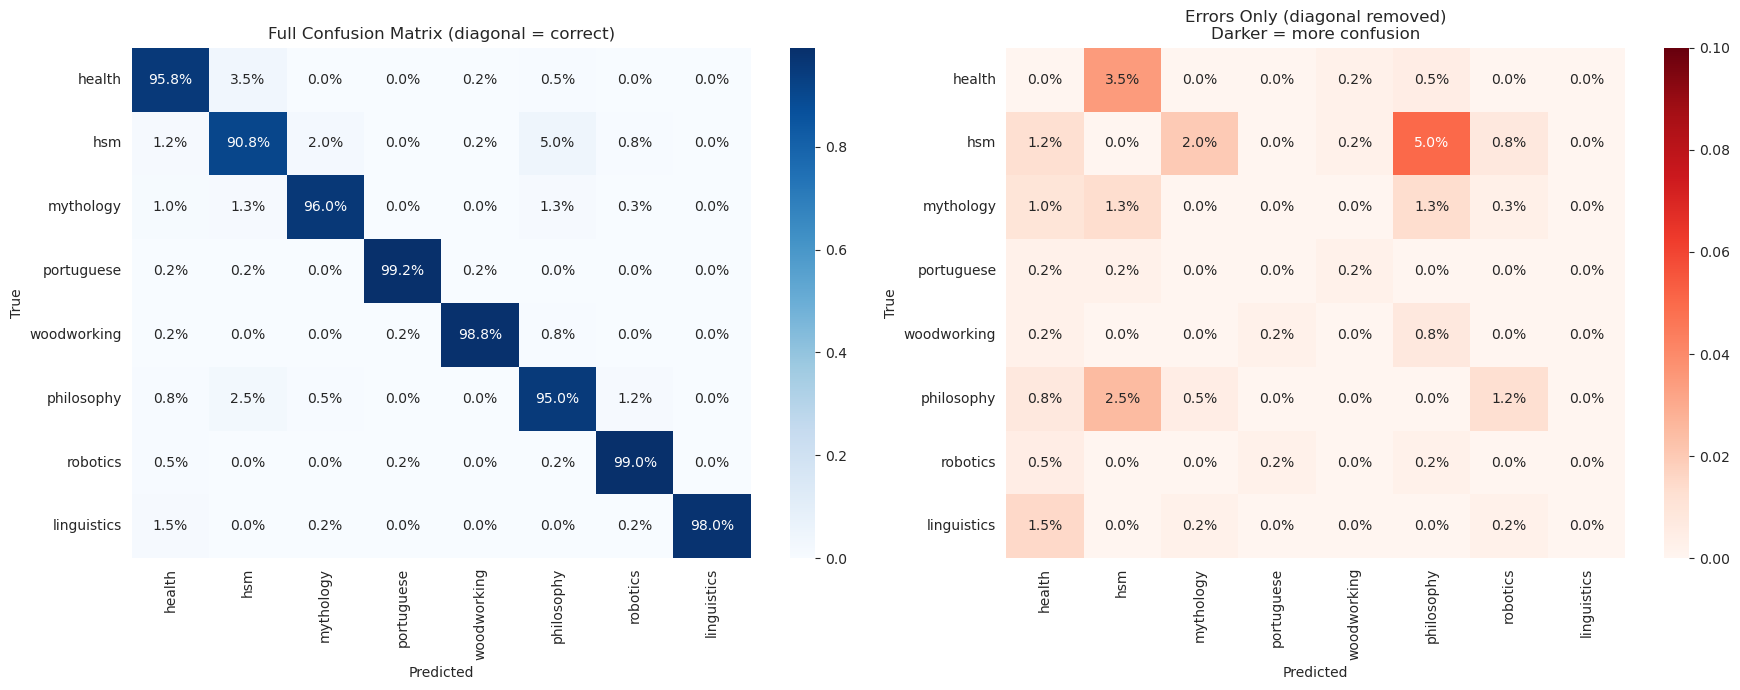

In [69]:
# Multi-class confusion matrix
cm_all = confusion_matrix(y_test_all, y_pred_all, normalize='true')

# Create a version with diagonal masked to highlight confusions
cm_offdiag = cm_all.copy()
np.fill_diagonal(cm_offdiag, 0)  # Zero out diagonal

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left: Full confusion matrix
sns.heatmap(cm_all, annot=True, fmt=".1%", cmap="Blues",
            xticklabels=present_categories, yticklabels=present_categories, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Full Confusion Matrix (diagonal = correct)")

# Right: Off-diagonal only (errors) - use Reds to highlight confusions
sns.heatmap(cm_offdiag, annot=True, fmt=".1%", cmap="Reds",
            xticklabels=present_categories, yticklabels=present_categories, ax=axes[1],
            vmin=0, vmax=0.1)  # Scale to max 10% error rate
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Errors Only (diagonal removed)\nDarker = more confusion")

plt.tight_layout()
plt.show()

### 🔍 Analysis Questions

Look at the confusion matrix and classification report:

1. **Which categories are easiest to classify?** Why do you think that is? 

🚧 TODO: **robotics**, **woodworking**, **portuguese**, **linguistics**, because the have the higher accuracy percentage in the diagonal of the full confusion matrix.

2. **Which categories get confused with each other?** Does this match your intuition? What is the weirdest high/low performance you see?

🚧 TODO: **philosophy** and **hsm** get confused the most (5.0%), **hsm** and **health** get also confuse (3.5%).
**philosophy** and **hsm** it is normal because both are about "history in some points (acient philisophes for exemple), but **hsm** and **health** is a little bit weird, because at first sight they have nothing in common.

3. **How do linguistics and philosophy perform compared to other categories?**

🚧 TODO: linguistics perform very good (98.0% accuracy) and has the highest precision (100%). philosophy does not perform very well compared to the others categories , it has only 95% of accuracy and the lowest ratios for precision, recall and f1-score

4. **What is the relationship between linguistics/philosophy and HSM (History of Science/Math)?**

🚧 TODO: No cofusion at all (0.0%) between linguistics and HSM, but there is 2.5% confusion between philosophy and HSM

In [70]:
# Cross-validation for robust evaluation
print("5-Fold Cross-Validation Results:")
print("-" * 40)

# 🚧 TODO: Run 5-fold cross-validation on the 8-class classifier
cv_scores = cross_val_score(lr_all, X, y, cv=5, scoring='accuracy')
print(f"Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"Per fold: {cv_scores}")

5-Fold Cross-Validation Results:
----------------------------------------
Accuracy: 0.980 ± 0.003
Per fold: [0.9825   0.981875 0.976875 0.984375 0.97625 ]


### 📊 Interpreting Cross-Validation Results

**What does cross-validation tell us?**

🚧 TODO: Answer the following questions:

- What does the mean accuracy tell us about our model?

The mean accuracy tell us that our model is very performant (98.0% accuracy).

- What does the standard deviation indicate?
- 
It indicates the variation arround the accuracy mean.

**Why is 8-class accuracy lower than binary?**

Beacause they are more boundaries to learn and more oppportunities for confusion between similair domains.


**Key insight:**

Cross-validation confirms the model is robust.

## Summary & Key Takeaways

### What We Learned:

1. **Data exploration matters** — Looking at actual examples helps build intuition before modeling

2. **Similar domains are harder** — Linguistics and philosophy share academic vocabulary, making classification harder than robotics vs mythology

3. **TF-IDF + Logistic Regression works well** — Even for challenging domain pairs, we can achieve good accuracy

4. **Feature importance is interpretable** — Looking at coefficients reveals which words drive predictions

5. **Context affects difficulty** — Adding more categories changes the classification landscape

### Connection to Next Class (Word2Vec):

TF-IDF treats words as independent features. But words have **relationships**:
- "syntax" and "grammar" are related
- "ethics" and "morality" are related

**Word embeddings** (Word2Vec, FastText) will capture these semantic relationships by learning dense vector representations where similar words are close together in vector space.